In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset
from pyg_classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from pyg_classifier.train import pool_train_loop
from pyg_classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that start of s1 is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?

Epoch 0: Training loss 15.1883, Validation loss 17.6875, learning rate 0.00100
	eadd_loss = -0.24842685461044312 vadd_loss = -0.35436201095581055
	 Validation MAE: 18.4745
Epoch 5: Training loss 3.5610, Validation loss 13.8764, learning rate 0.00100
	eadd_loss = -0.36845316489537555 vadd_loss = -0.3711857795715332
	 Validation MAE: 14.7072
Epoch 10: Training loss 2.7343, Validation loss 14.3918, learning rate 0.00100
	eadd_loss = -0.25577692190806073 vadd_loss = -0.2857539653778076
	 Validation MAE: 15.1166
Epoch 15: Training loss 2.5804, Validation loss 14.1393, learning rate 0.00100
	eadd_loss = -0.23420757055282593 vadd_loss = -0.31484484672546387
	 Validation MAE: 14.8951
Epoch 20: Training loss 2.0443, Validation loss 14.2432, learning rate 0.00100
	eadd_loss = -0.19339150190353394 vadd_loss = -0.23345303535461426
	 Validation MAE: 14.9382
Epoch 25: Training loss 1.8964, Validation loss 13.8405, learning rate 0.00100
	eadd_loss = -0.1795496145884196 vadd_loss = -0.2302010059356689

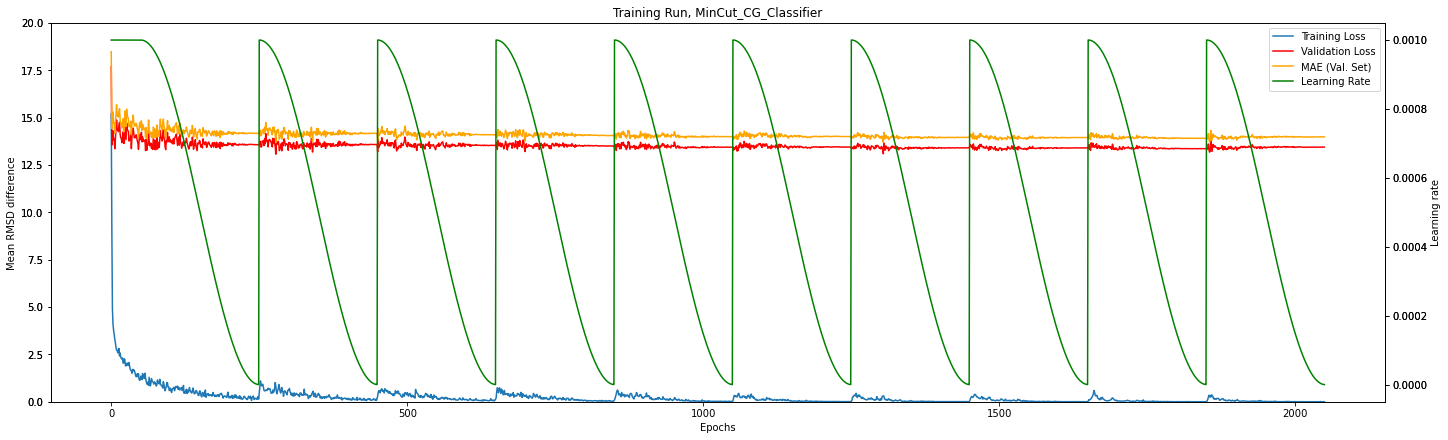

In [33]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "pyg_model_data/"


epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=2000,
    sched_T0=200,
    vectorize=vectorize,
    k=k,
    burn_in=50)

In [3]:
#get training run data

file = "pyg_model_data/2022-05-03_10-5_DMoN_CG_Classifier/loss_data.txt"

file_lines = []
with open(file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss 0.0008 in epoch 4399
Minimum Validation Loss (after 50 epochs) 37.4445 in epoch 93
Minimum MAE (after 50 epochs) 13.5591 in epoch 4291


Validation Loss at 1304 is 13.0861
5 before select
13.4204, 13.3416, 13.4765, 13.3743, 13.4072
5 after select
13.6519, 13.4194, 13.2770, 13.5038, 13.4847
MAE at 1304 is 13.6773


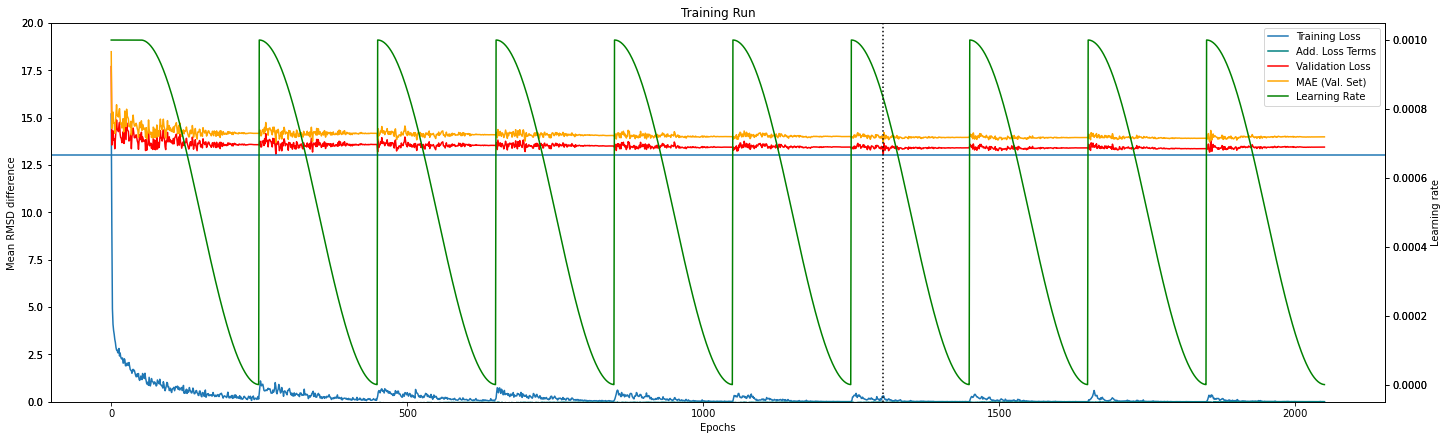

In [51]:
#plot the training run
select = 1304
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=13)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Test Set
tensor([[25.4170]], device='cuda:0') tensor([[25.3984]], device='cuda:0') 0.00017242145258933306
tensor([[0.]], device='cuda:0') tensor([[26.1609]], device='cuda:0') 25.66085433959961
Mean Test loss: 	 11.9129
Std. Dev. of Test loss:  9.3500
Min loss: 		 0.0002
First Quantile: 	 3.1594
Median: 		 9.9531
Third Quantile: 	 23.5592
Max Loss: 		 25.6609
LinregressResult(slope=-0.2773778303969646, intercept=23.846265308467515, rvalue=-0.05512609399438331, pvalue=0.3607024453471763, stderr=0.30296139246587267, intercept_stderr=7.717812689695506)


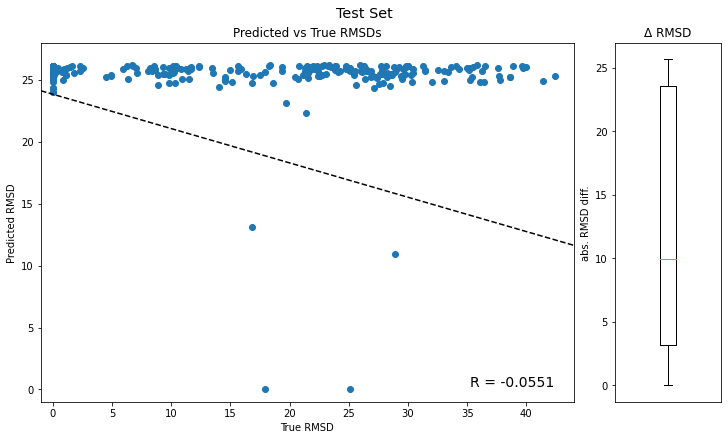

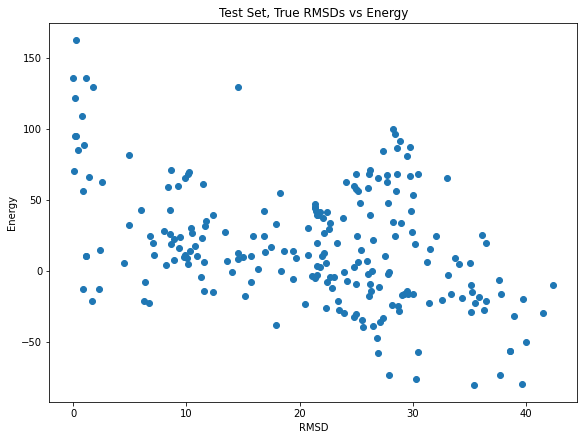

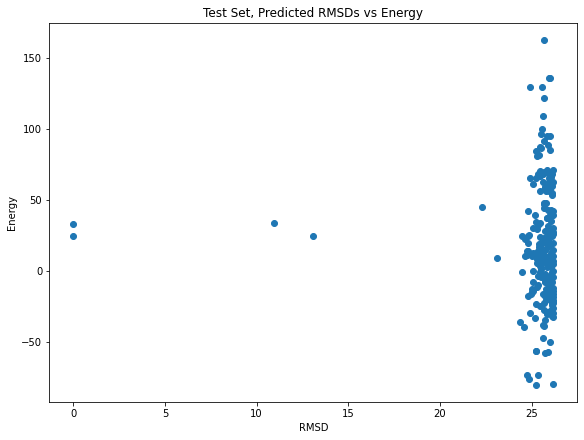

5S and tRNA Test Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[0.]], device='cuda:0') tensor([[26.1613]], device='cuda:0') 25.661272048950195
Mean Test loss: 	 7.4971
Std. Dev. of Test loss:  6.7480
Min loss: 		 0.0000
First Quantile: 	 2.5848
Median: 		 6.1205
Third Quantile: 	 9.9467
Max Loss: 		 25.6613
LinregressResult(slope=0.6493274977231641, intercept=1.0974063064401953, rvalue=0.5597581728090871, pvalue=2.504120314890668e-90, stderr=0.029236460288653586, intercept_stderr=0.7031716947514552)


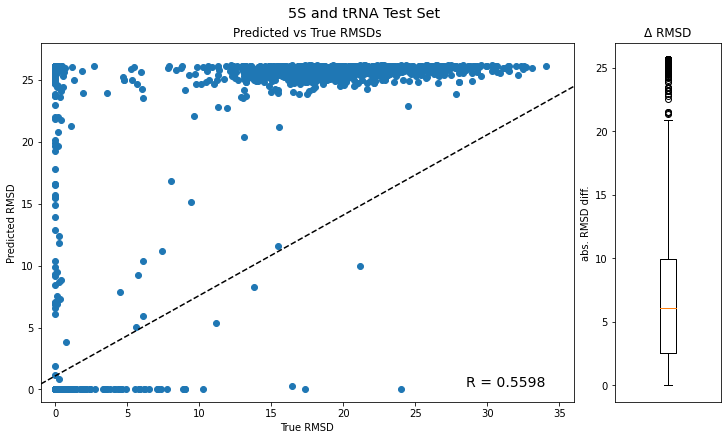

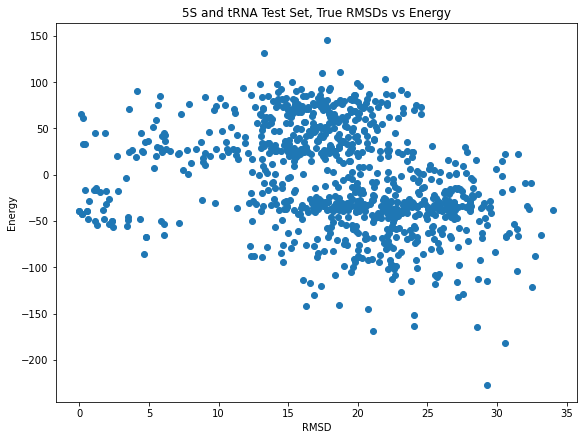

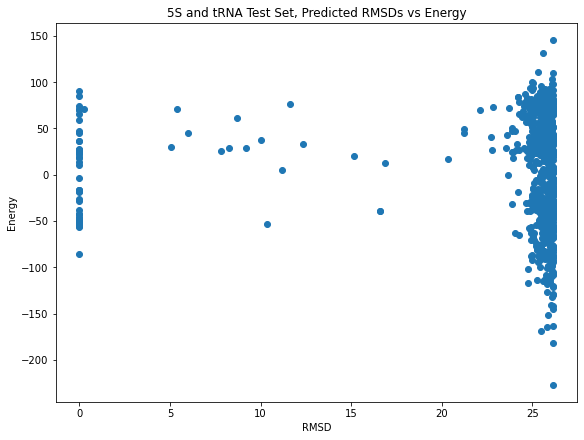

Training Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[0.0330]], device='cuda:0') tensor([[22.8497]], device='cuda:0') 22.316669464111328
Mean Test loss: 	 5.8461
Std. Dev. of Test loss:  4.4784
Min loss: 		 0.0000
First Quantile: 	 2.1375
Median: 		 5.1034
Third Quantile: 	 8.8225
Max Loss: 		 22.3167
LinregressResult(slope=0.7234120809969875, intercept=2.3513462226578064, rvalue=0.7159934536900155, pvalue=1.9924113739132124e-120, stderr=0.0256191131301077, intercept_stderr=0.5977651223064169)


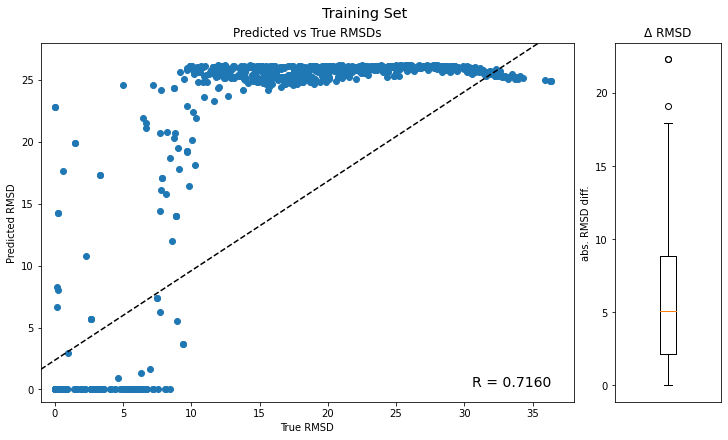

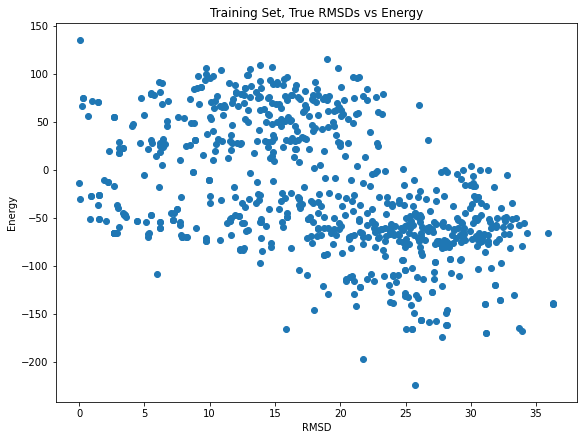

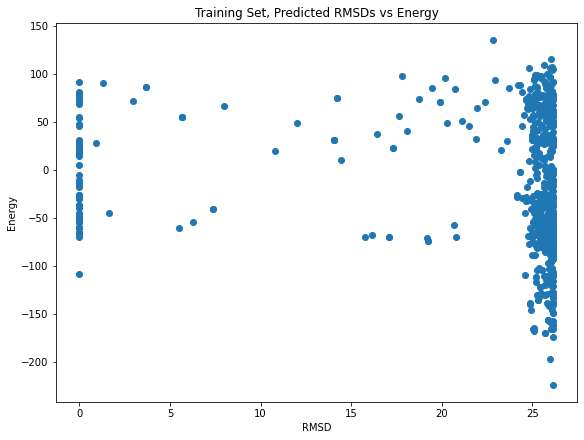

Validation Set
tensor([[26.1660]], device='cuda:0') tensor([[26.1358]], device='cuda:0') 0.00045495512313209474
tensor([[61.9850]], device='cuda:0') tensor([[25.6957]], device='cuda:0') 35.78927993774414
Mean Test loss: 	 13.2664
Std. Dev. of Test loss:  8.3247
Min loss: 		 0.0005
First Quantile: 	 7.0004
Median: 		 11.8670
Third Quantile: 	 18.7798
Max Loss: 		 35.7893
LinregressResult(slope=0.6757660130097131, intercept=6.135975886160178, rvalue=0.11952904568114729, pvalue=0.01733069437314189, stderr=0.28278084129562264, intercept_stderr=7.204365010519506)


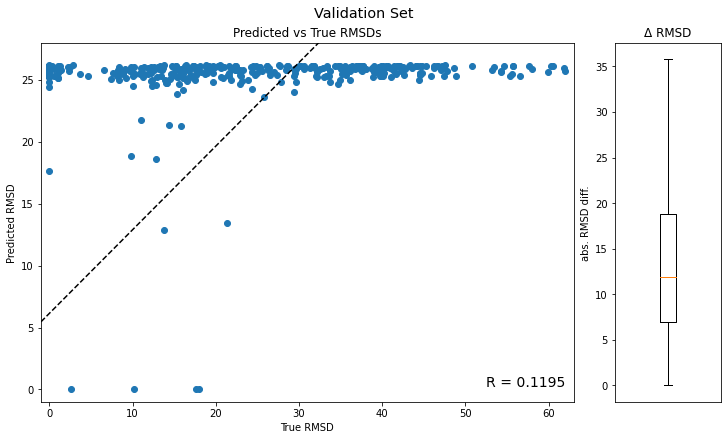

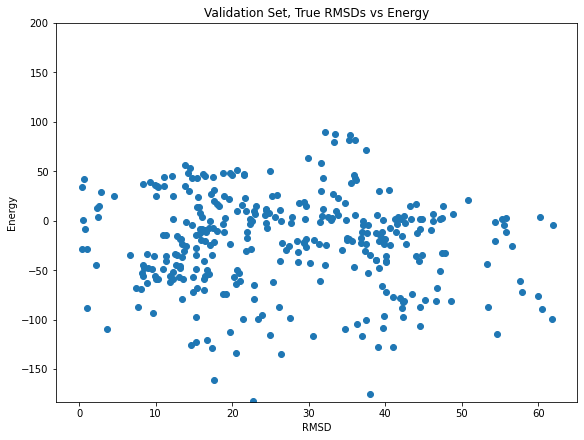

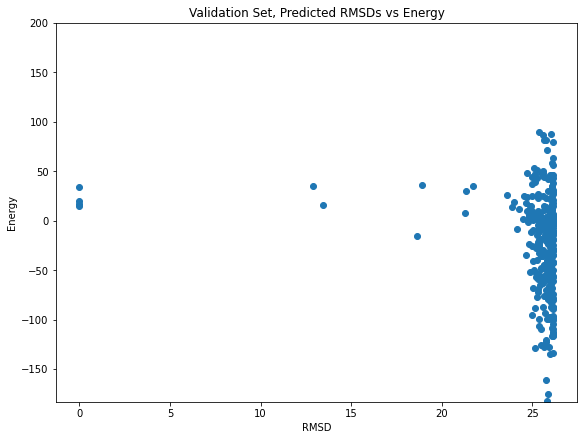

LinregressResult(slope=0.649201202628237, intercept=4.938616055083047, rvalue=0.33826074410500967, pvalue=3.125492185689724e-41, stderr=0.04680520865722163, intercept_stderr=1.1712607731747038)


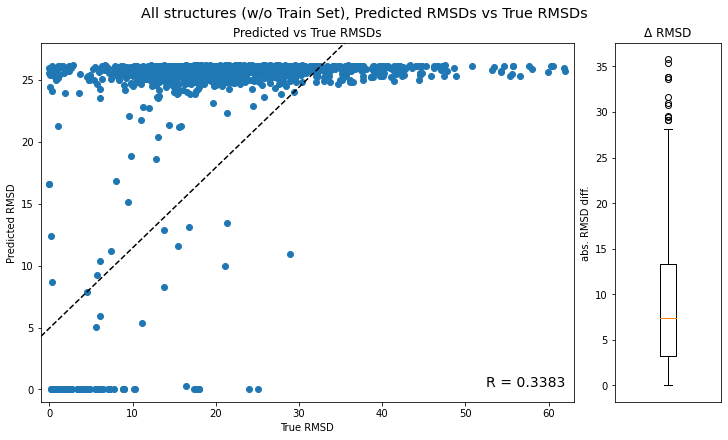

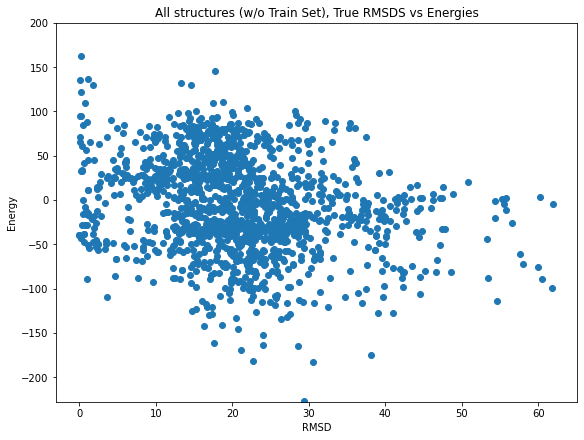

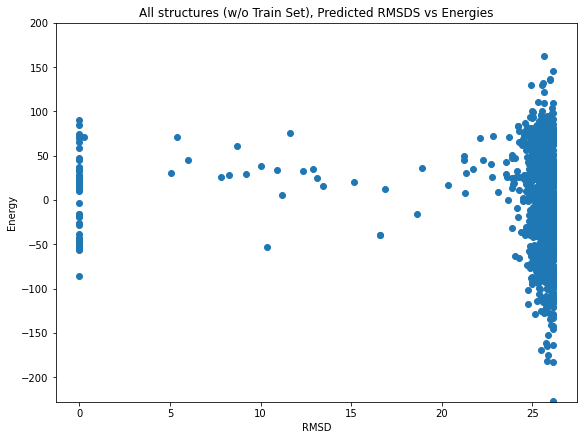

In [52]:
#Test
from pyg_classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    num_node_feats = training_dataset.num_node_features
    model = DMoN_CG_Classifier(num_node_feats).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load("pyg_model_data/2022-05-03_12-15_MinCut_CG_Classifier/model_data/epoch_1304.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9750313254102113, intercept=0.5100603045504002, rvalue=0.976961212669297, pvalue=1.6977330969412909e-186, stderr=0.012844103082400825, intercept_stderr=0.2815298435461595)


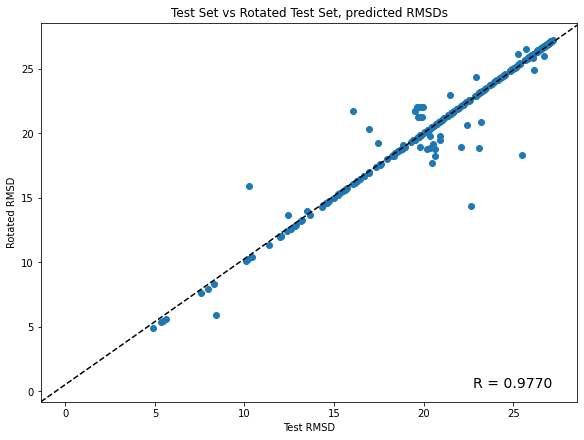

LinregressResult(slope=0.9855608488587203, intercept=0.1517586900111656, rvalue=0.9899266911777943, pvalue=1.6312193187643196e-235, stderr=0.00849999508789229, intercept_stderr=0.1211344304635681)


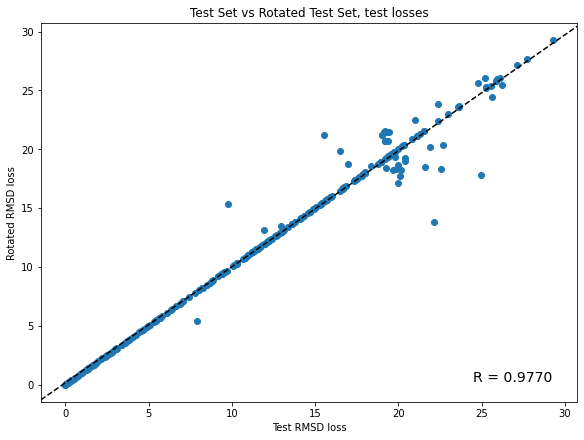

LinregressResult(slope=0.955564554535026, intercept=0.9678546075175447, rvalue=0.9602036854049686, pvalue=0.0, stderr=0.008453875440520682, intercept_stderr=0.17387826502321252)


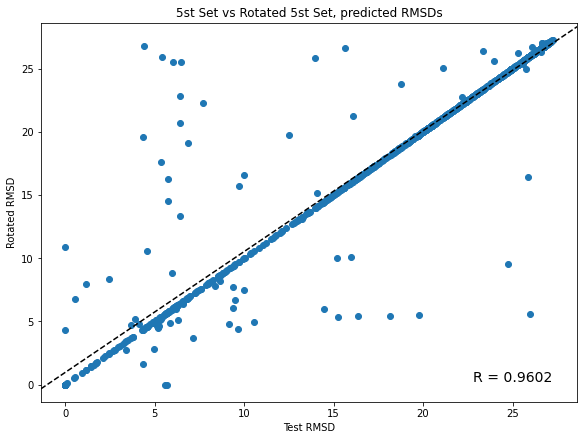

LinregressResult(slope=0.9575762299931067, intercept=0.3226756793034591, rvalue=0.9088153472350062, pvalue=0.0, stderr=0.01336988559386106, intercept_stderr=0.09212389023577501)


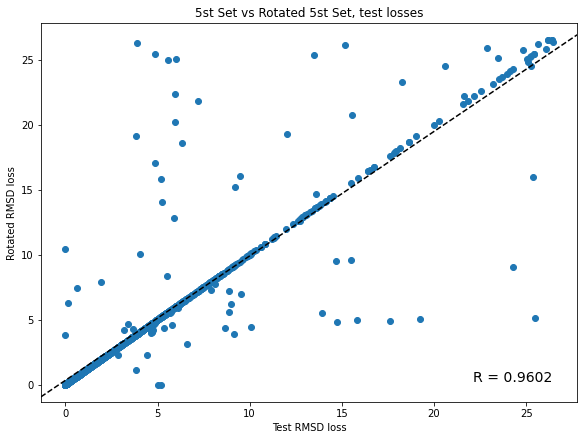

In [36]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")